# metadata_df

In [1]:
import pandas as pd
pd.set_option('display.max_columns', 200)

In [2]:
from io import BytesIO
from office365.runtime.auth.authentication_context import AuthenticationContext
from office365.sharepoint.client_context import ClientContext
import pandas as pd
pd.set_option('display.max_columns', 200)

# Constants for the SharePoint connection
TENANT_ID = "c9dc265f-a55d-466a-920c-9eb2e81f750f"
N2_URL = "https://n2applied.sharepoint.com/sites/"
APPLICATION_ID = "f83dae31-1ffa-4457-8e00-bc48c0f02a29"

def authenticate_sharepoint(site_name: str):
    """Authenticate and return a client context for a SharePoint site."""
    site_url = f'{N2_URL}{site_name}'
    ctx_auth = AuthenticationContext(url=site_url)
    ctx_auth.with_interactive(TENANT_ID, APPLICATION_ID)
    ctx = ClientContext(site_url, ctx_auth)
    return ctx

def download_file(ctx: ClientContext, folder_path: str, file_name: str):
    """Download a file from SharePoint."""
    file_path = f'{folder_path}/{file_name}'
    with open(file_name, "wb") as file:
        ctx.web.get_file_by_server_relative_url(file_path).download(file).execute_query()

def load_excelsheet(ctx: ClientContext, folder_path: str, file_name: str, sheet_name: str) -> pd.DataFrame:
    """Load an Excel sheet from SharePoint into a pandas DataFrame."""
    file_path = f'{folder_path}/{file_name}'
    excel_file = ctx.web.get_file_by_server_relative_url(file_path)
    file_content = excel_file.get_content().execute_query()
    excel_sheet = pd.read_excel(io=BytesIO(file_content.value), sheet_name=sheet_name, skiprows=8)
    return excel_sheet

if __name__ == "__main__":
    # Fill in these variables with your specific values
    site_name = 'RD'  # Replace with your actual site name
    folder_path = "Projects/Yara-N2, Effect of oxygen in PNG/WP8_Oxygen_Experimental"  # Replace with your actual folder path
    file_name = "2025-Testplan_and_log_WP8-Oxygen.xlsx"  # Replace with your actual file name
    sheet_name = '2024-1076-Testlog'  # Replace with the sheet name you want
    # Authenticate and obtain client context
    ctx = authenticate_sharepoint(site_name)
    # Download the file
    download_file(ctx, folder_path, file_name)
    # Load the Excel sheet into a DataFrame
    excel_data = load_excelsheet(ctx, folder_path, file_name, sheet_name)
    metadata_df = excel_data

In [3]:
# import pandas as pd
# metadata_df = pd.read_csv('2025-Testplan_and_log_WP8-Oxygen_local.csv')
# # metadata_df

In [4]:
# for columns in df.columns:
#     print(columns)
columns_to_include = ['Test_ID',
                      'Run Order',
                      'Date [yyyy.mm.dd]',
                      'HW start Time [hh:mm]',
                      'Exp start Time [hh:mm]',
                      'Exp stop Time [hh:mm]',
                      'Duration [min]',
                      'Quench diameter [mm]',
                      'Quench distance [mm]',
                      'Target Power [kW]',
                      'Target enthalpy [kWh/Nm³]',
                      'Oxygen Percentage', 
                      'Setpoint total gasflow [Nm³/h]',
                      'Setpoint airflow FV2201 [Nm³/h]',
                      'Setpoint Oxygen flow [Nm³/h]',
                      'FTIR channel']
metadata_df = metadata_df[columns_to_include].head(14)
#------------------------------------------------------------------------------------------------------------------------
import pandas as pd
# Create new datetime columns directly
metadata_df['hw_start'] = pd.to_datetime(metadata_df['Date [yyyy.mm.dd]'].astype(str) + ' ' + metadata_df['HW start Time [hh:mm]'].astype(str)).dt.tz_localize('Europe/Oslo')
metadata_df['exp_start'] = pd.to_datetime(metadata_df['Date [yyyy.mm.dd]'].astype(str) + ' ' + metadata_df['Exp start Time [hh:mm]'].astype(str)).dt.tz_localize('Europe/Oslo')
metadata_df['exp_stop'] = pd.to_datetime(metadata_df['Date [yyyy.mm.dd]'].astype(str) + ' ' + metadata_df['Exp stop Time [hh:mm]'].astype(str)).dt.tz_localize('Europe/Oslo')

## Exclude test ids

In [5]:
test_ids_to_exclude = ['2025-exp4']
metadata_df = metadata_df[~metadata_df['Test_ID'].isin(test_ids_to_exclude)]

metadata_df_copy = metadata_df.set_index('Test_ID').copy()
metadata_dict = metadata_df_copy.to_dict('index')

# This eliminates need for filtering in subsequent operations
print(f"antall exp = {len(metadata_dict.keys())}\nexcluded = {test_ids_to_exclude}")

antall exp = 13
excluded = ['2025-exp4']


# sensor_dict

In [6]:
from influxdb import InfluxDBClient
import pandas as pd

# Constants
HOST = '192.168.1.3'
DATABASE = 'rnd'
SELECTED_MACHINE = 'TS17'  # Avoid hardcoding by fetching dynamically or using config

# Use a context manager to handle the InfluxDB client connection
with InfluxDBClient(host=HOST, database=DATABASE) as client:
    # Fetch measurements and filter for the selected machine
    measurements = client.query('SHOW MEASUREMENTS')
    selected_machine = next((row['name'] for row in measurements.get_points() if row['name'] == SELECTED_MACHINE), None)

    if not selected_machine:
        raise ValueError(f"Machine '{SELECTED_MACHINE}' not found in measurements.")

    # Fetch equipment and data tag values in a single query
    tag_query = f'SHOW TAG VALUES FROM "{SELECTED_MACHINE}" WITH KEY IN ("equipment", "data")'
    tag_results = client.query(tag_query)

    # Extract equipment and data lists
    equipment_list = [row['value'] for row in tag_results.get_points() if row['key'] == 'equipment']
    data_list = [row['value'] for row in tag_results.get_points() if row['key'] == 'data']

# # Print results
# print("Selected Machine:", selected_machine)
# print("Equipment List:", equipment_list)
# print("Data List:", data_list)

# for equipment in equipment_list:
#      for data in data_list:
#          print(equipment,data)

import pandas as pd
from functools import reduce

# Hardcoded equipment and data lists
f_equipment_list = ['G2101', 'FV2001', 'FV2011']
f_data_list = ['arc_voltage', 'arc_power', 'arc_current', 'flow']

# Initialize a dictionary to store DataFrames for each Test ID
sensor_dict = {}

for Test_ID, metadata in metadata_dict.items():
    exp_start = metadata['exp_start']
    exp_stop = metadata['exp_stop']
    
    # Initialize an empty list to store DataFrames for the current Test ID
    dataframes = []
    
    # Iterate over equipment and data lists
    for equipment in f_equipment_list:
        for data in f_data_list:
            query = f"""
            SELECT mean(value) AS mean_value
            FROM {selected_machine}
            WHERE equipment = '{equipment}' AND data = '{data}'
            AND time > '{exp_start.isoformat()}' AND time < '{exp_stop.isoformat()}'
            GROUP BY time(30s, -30s)
            """
            data_points = client.query(query)
            data_rows = list(data_points.get_points())
            
            if data_rows:
                # Create a DataFrame for the current equipment and data
                temp_df = pd.DataFrame({
                    'timestamp': pd.to_datetime([dp['time'] for dp in data_rows]).tz_convert('Europe/Oslo'),
                    f'{equipment}({data})': [dp['mean_value'] for dp in data_rows]
                })

                # Append the DataFrame to the list
                dataframes.append(temp_df)
    
    # Merge all DataFrames for the current Test ID on the 'timestamp' column
    if dataframes:
        merged_df = reduce(lambda left, right: pd.merge(left, right, on='timestamp', how='outer'), dataframes)
        # merged_df.set_index('timestamp', inplace=True)
    else:
        merged_df = pd.DataFrame()

    # Store the merged DataFrame in the dictionary with Test ID as the key
    sensor_dict[Test_ID] = merged_df

# ftir_dict

In [7]:
from influxdb import InfluxDBClient
import pandas as pd

# Constants
HOST = '192.168.1.3'
DATABASE = 'instruments'
SELECTED_MACHINE = 'protea_ftir_2'  # Avoid hardcoding by fetching dynamically or using config

# Use a context manager to handle the InfluxDB client connection
with InfluxDBClient(host=HOST, database=DATABASE) as client:
    # Fetch measurements and filter for the selected machine
    measurements = client.query('SHOW MEASUREMENTS')
    selected_machine = next((row['name'] for row in measurements.get_points() if row['name'] == SELECTED_MACHINE), None)

    if not selected_machine:
        raise ValueError(f"Machine '{SELECTED_MACHINE}' not found in measurements.")

    # Fetch equipment and data tag values in a single query
    tag_query = f'SHOW TAG VALUES FROM "{SELECTED_MACHINE}" WITH KEY IN ("equipment", "data")'
    tag_results = client.query(tag_query)

    # Extract equipment and data lists
    equipment_list = [row['value'] for row in tag_results.get_points() if row['key'] == 'equipment']
    data_list = [row['value'] for row in tag_results.get_points() if row['key'] == 'data']

# Print results
# print("Selected Machine:", selected_machine)
# print("Equipment List:", equipment_list)
# print("Data List:", data_list)

# for equipment in equipment_list:
#      for data in data_list:
#          print(equipment,data)

import pandas as pd
from functools import reduce

# Hardcoded equipment and data lists
f_equipment_list = ['Channel_2']
f_data_list = ['NO_Corrected', 'NO2_Corrected']

# Initialize a dictionary to store DataFrames for each Test ID
ftir_dict = {}

for Test_ID, metadata in metadata_dict.items():
    exp_start = metadata['exp_start']
    exp_stop = metadata['exp_stop']
    
    # Initialize an empty list to store DataFrames for the current Test ID
    dataframes = []
    
    # Iterate over equipment and data lists
    for equipment in f_equipment_list:
        for data in f_data_list:
            query = f"""
            SELECT mean(value) AS mean_value
            FROM {selected_machine}
            WHERE equipment = '{equipment}' AND data = '{data}'
            AND time > '{exp_start.isoformat()}' AND time < '{exp_stop.isoformat()}'
            GROUP BY time(30s, -30s)
            """
            data_points = client.query(query)
            data_rows = list(data_points.get_points())
            
            if data_rows:
                # Create a DataFrame for the current equipment and data
                temp_df = pd.DataFrame({
                    'timestamp': pd.to_datetime([dp['time'] for dp in data_rows]).tz_convert('Europe/Oslo'),
                    f'{equipment}({data})': [dp['mean_value'] for dp in data_rows]
                })

                # Append the DataFrame to the list
                dataframes.append(temp_df)
    
    # Merge all DataFrames for the current Test ID on the 'timestamp' column
    if dataframes:
        merged_df = reduce(lambda left, right: pd.merge(left, right, on='timestamp', how='outer'), dataframes)
        # merged_df.set_index('timestamp', inplace=True)
    else:
        merged_df = pd.DataFrame()
    
    # Store the merged DataFrame in the dictionary with Test ID as the key
    ftir_dict[Test_ID] = merged_df

# merged_influx_df

In [8]:
# Initialize a dictionary to store merged results
merged_dict = {}

# Iterate over the keys (Test_IDs)
for Test_ID in sensor_dict.keys():
    # Merge the DataFrames from both dictionaries on the 'timestamp' column
    influx_df = pd.merge(sensor_dict[Test_ID], ftir_dict[Test_ID], on='timestamp', how='outer')

    influx_df['NO/NO2'] = influx_df['Channel_2(NO_Corrected)'] / influx_df['Channel_2(NO2_Corrected)']
    influx_df['NOx%'] = influx_df['Channel_2(NO_Corrected)'] + influx_df['Channel_2(NO2_Corrected)']
    influx_df['FV2001(flow)+FV2011(flow)'] = influx_df['FV2001(flow)'] + influx_df['FV2011(flow)']
    std_temp = 273
    std_pressure = 101325
    Mol_mas_N = 14
    R = 8.3145
    influx_df['EC_calc'] = (100000 * std_temp * R * influx_df['G2101(arc_power)']) / (std_pressure * Mol_mas_N * influx_df['FV2001(flow)+FV2011(flow)'] * influx_df['NOx%'])

    influx_df['enthalpy_calc'] = influx_df['G2101(arc_power)'] / influx_df['FV2001(flow)+FV2011(flow)']

    A = influx_df['FV2001(flow)']/influx_df['FV2001(flow)+FV2011(flow)']
    influx_df['O2%_calc'] = (0.995 - A*(0.995-0.2095))*100
    # Store the merged DataFrame in the dictionary with Test ID as the key
    merged_dict[Test_ID] = influx_df

# Concatenate all DataFrames in merged_dict into one large DataFrame
merged_influx_df = pd.concat(merged_dict.values(), ignore_index=True)

merged_influx_df.to_csv('merged_influx_df.csv')

# stat_dict

In [9]:
import pandas as pd

stat_dict = {}

# Iterate over the keys (Test_IDs)
for Test_ID in sensor_dict.keys():
    merged_df = pd.merge(sensor_dict[Test_ID], ftir_dict[Test_ID], on='timestamp', how='outer')

    merged_df['NO/NO2']=merged_df['Channel_2(NO_Corrected)']/merged_df['Channel_2(NO2_Corrected)']
    merged_df['NOx%']=merged_df['Channel_2(NO_Corrected)']+merged_df['Channel_2(NO2_Corrected)']
    merged_df['FV2001(flow)+FV2011(flow)']=merged_df['FV2001(flow)']+merged_df['FV2011(flow)']
    
    std_temp = 273
    std_pressure = 101325
    Mol_mas_N = 14
    R = 8.3145
    merged_df['EC_calc'] = (100000*std_temp*R*merged_df['G2101(arc_power)']) / (std_pressure*Mol_mas_N*merged_df['FV2001(flow)+FV2011(flow)']*merged_df['NOx%'])
    merged_df['enthalpy_calc'] = merged_df['G2101(arc_power)'] / merged_df['FV2001(flow)+FV2011(flow)']

    A = merged_df['FV2001(flow)']/(merged_df['FV2001(flow)']+merged_df['FV2011(flow)'])
    merged_df['O2%_calc'] = (0.995-A*(0.995-0.2095))*100

    # Exclude the 'timestamp' column from calculations
    data_columns = merged_df.columns.difference(['timestamp'])
    mean_values = merged_df[data_columns].mean()
    std_values = merged_df[data_columns].std()
    cv_values = std_values / mean_values

    # Store the results in a DataFrame
    stats = {'mean': mean_values, 'std': std_values, 'cv': cv_values}
    stat_df = pd.DataFrame(stats).transpose()
    stat_df['Test_ID'] = Test_ID
    stat_dict[Test_ID] = stat_df
# Concatenate all DataFrames into one
all_stats_df = pd.concat(stat_dict.values(), ignore_index=False)
# Rearrange the DataFrame
df = pd.DataFrame()

# For each parameter, append mean, std, cv in order
for parameter in data_columns:
    df = pd.concat(
        [df, 
         all_stats_df.loc['mean', [parameter]].reset_index(drop=True).rename(columns={parameter: parameter + '_mean'}),
         all_stats_df.loc['std', [parameter]].reset_index(drop=True).rename(columns={parameter: parameter + '_std'}),
         all_stats_df.loc['cv', [parameter]].reset_index(drop=True).rename(columns={parameter: parameter + '_cv'})],
        axis=1
    )
# Add Test_ID as a column
df['Test_ID'] = all_stats_df.iloc[::3, all_stats_df.columns.get_loc('Test_ID')].to_list()

test_ids_to_exclude = ['2024-1076-08', '2024-1076-01']
df = df[~df['Test_ID'].isin(test_ids_to_exclude)]

print("Reformatted Statistics DataFrame:")
print(df.to_string(index=False))

# reformatted_stats_df

Reformatted Statistics DataFrame:
 Channel_2(NO2_Corrected)_mean  Channel_2(NO2_Corrected)_std  Channel_2(NO2_Corrected)_cv  Channel_2(NO_Corrected)_mean  Channel_2(NO_Corrected)_std  Channel_2(NO_Corrected)_cv  EC_calc_mean  EC_calc_std  EC_calc_cv  FV2001(flow)_mean  FV2001(flow)_std  FV2001(flow)_cv  FV2001(flow)+FV2011(flow)_mean  FV2001(flow)+FV2011(flow)_std  FV2001(flow)+FV2011(flow)_cv  FV2011(flow)_mean  FV2011(flow)_std  FV2011(flow)_cv  G2101(arc_current)_mean  G2101(arc_current)_std  G2101(arc_current)_cv  G2101(arc_power)_mean  G2101(arc_power)_std  G2101(arc_power)_cv  G2101(arc_voltage)_mean  G2101(arc_voltage)_std  G2101(arc_voltage)_cv  NO/NO2_mean  NO/NO2_std  NO/NO2_cv  NOx%_mean  NOx%_std  NOx%_cv  O2%_calc_mean  O2%_calc_std  O2%_calc_cv  enthalpy_calc_mean  enthalpy_calc_std  enthalpy_calc_cv    Test_ID
                      1.877811                      0.012623                     0.006722                      1.224932                     0.005487               

# final_df

In [10]:
final_df = pd.merge(df, metadata_df_copy, on='Test_ID')
print(final_df.to_string())

    Channel_2(NO2_Corrected)_mean  Channel_2(NO2_Corrected)_std  Channel_2(NO2_Corrected)_cv  Channel_2(NO_Corrected)_mean  Channel_2(NO_Corrected)_std  Channel_2(NO_Corrected)_cv  EC_calc_mean  EC_calc_std  EC_calc_cv  FV2001(flow)_mean  FV2001(flow)_std  FV2001(flow)_cv  FV2001(flow)+FV2011(flow)_mean  FV2001(flow)+FV2011(flow)_std  FV2001(flow)+FV2011(flow)_cv  FV2011(flow)_mean  FV2011(flow)_std  FV2011(flow)_cv  G2101(arc_current)_mean  G2101(arc_current)_std  G2101(arc_current)_cv  G2101(arc_power)_mean  G2101(arc_power)_std  G2101(arc_power)_cv  G2101(arc_voltage)_mean  G2101(arc_voltage)_std  G2101(arc_voltage)_cv  NO/NO2_mean  NO/NO2_std  NO/NO2_cv  NOx%_mean  NOx%_std   NOx%_cv  O2%_calc_mean  O2%_calc_std   O2%_calc_cv  enthalpy_calc_mean  enthalpy_calc_std  enthalpy_calc_cv     Test_ID  Run Order Date [yyyy.mm.dd] HW start Time [hh:mm] Exp start Time [hh:mm] Exp stop Time [hh:mm] Duration [min]  Quench diameter [mm]  Quench distance [mm]  Target Power [kW]  Target enthalpy 

# DoE_df

In [11]:
columns = ['Test_ID', 'Run Order', 'O2%_calc_mean', 'enthalpy_calc_mean', 'EC_calc_mean', 'G2101(arc_voltage)_std', 'G2101(arc_voltage)_mean', 'NO/NO2_mean']
doe_df = final_df[columns]
doe_df.to_csv('doe.csv')
doe_df

,Test_ID,Run Order,O2%_calc_mean,enthalpy_calc_mean,EC_calc_mean,G2101(arc_voltage)_std,G2101(arc_voltage)_mean,NO/NO2_mean
0,2025-exp3,1,20.950000,0.998975,51.520973,4.522904,701.732570,0.652348
1,2025-exp8,2,24.944171,0.999990,47.576678,3.322697,691.704988,0.521625
2,2025-exp9,3,29.989020,0.900883,43.041342,3.970131,738.355938,0.447260
3,2025-exp7,4,35.489310,0.900409,42.522482,4.501487,726.796060,0.343974
4,2025-exp5,5,35.485184,0.900153,42.417691,4.128524,734.754886,0.345835
5,2025-exp10,6,40.074060,0.989756,44.892742,3.206011,668.275094,0.303372
6,2025-exp11,7,45.071732,0.902654,42.674149,6.017011,700.229016,0.278655
7,2025-exp1,9,20.950000,0.803197,50.287649,4.296605,828.111529,0.727445
8,2025-exp6,11,35.483068,0.900289,42.692394,4.137606,706.105012,0.325432
9,2025-exp2,10,50.070978,0.802778,41.312385,4.536153,731.532345,0.251180


# Box Plot (Test_IDs)

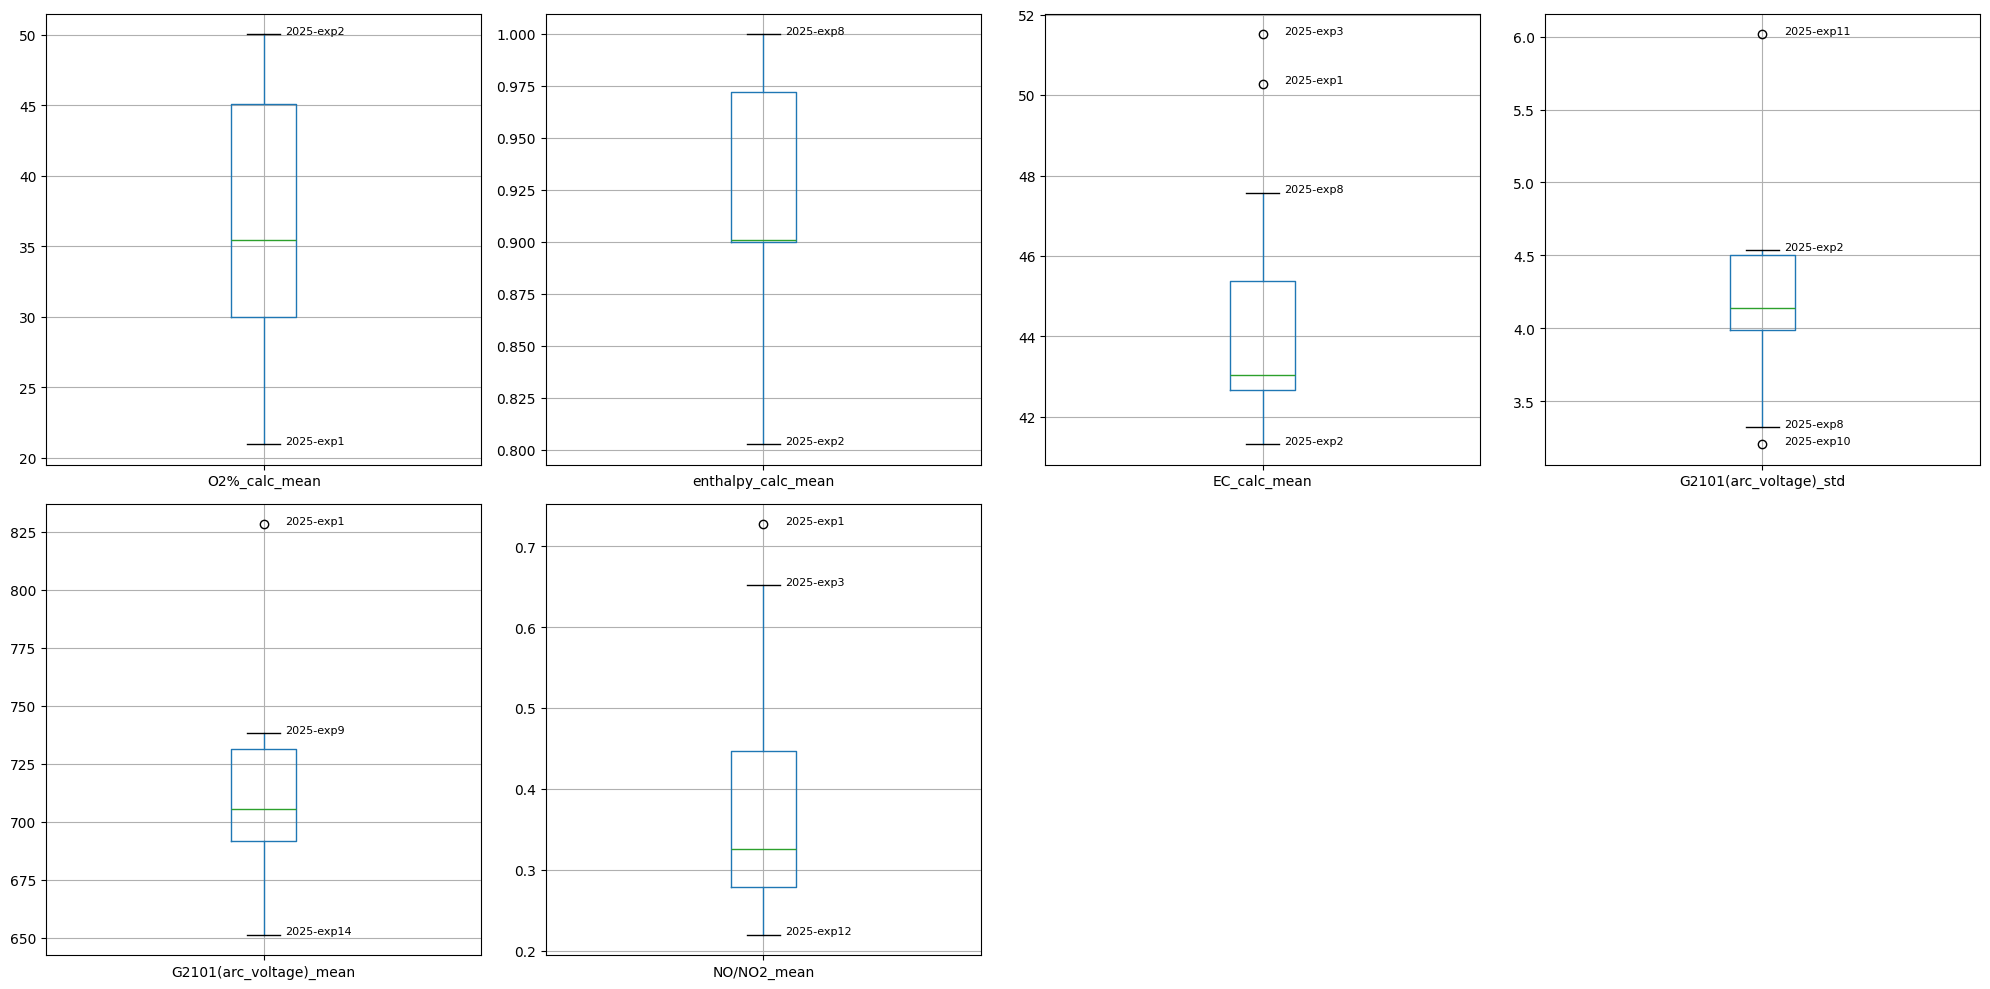

In [12]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

def plot_boxplots_with_outliers(df, columns=None):
    ncols = 4
    columns_to_plot = columns if columns else df.select_dtypes(include='number').columns
    nrows = int(np.ceil(len(columns_to_plot) / ncols))

    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(5 * ncols, 5 * nrows))
    axes = axes.flatten()

    for i, column in enumerate(columns_to_plot):
        ax = df.boxplot(column=column, ax=axes[i])
        q1, q3 = df[column].quantile([0.25, 0.75])
        iqr = q3 - q1
        lower_bound = q1 - 1.5 * iqr
        upper_bound = q3 + 1.5 * iqr

        # Outliers
        outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)]
        # Non-outlier max and min values
        non_outlier_df = df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]
        max_value = non_outlier_df[column].max()
        min_value = non_outlier_df[column].min()
        non_outliers = df[df[column].isin([max_value, min_value])]

        # Annotations for outliers and max, min non-outliers
        for idx, row in pd.concat([outliers, non_outliers]).iterrows():
            ax.annotate(f"{row['Test_ID']}", xy=(1, row[column]), xytext=(1.05, row[column]), fontsize=8, ha='left')

    # Hide any unused subplots
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()

plot_boxplots_with_outliers(final_df, columns=['O2%_calc_mean','enthalpy_calc_mean', 'EC_calc_mean', 'G2101(arc_voltage)_std', 'G2101(arc_voltage)_mean', 'NO/NO2_mean'])
# plot_boxplots_with_outliers(final_df, columns=['G2101(arc_voltage)_mean', 'G2101(arc_voltage)_std', 'G2101(arc_voltage)_cv'])

# Checks

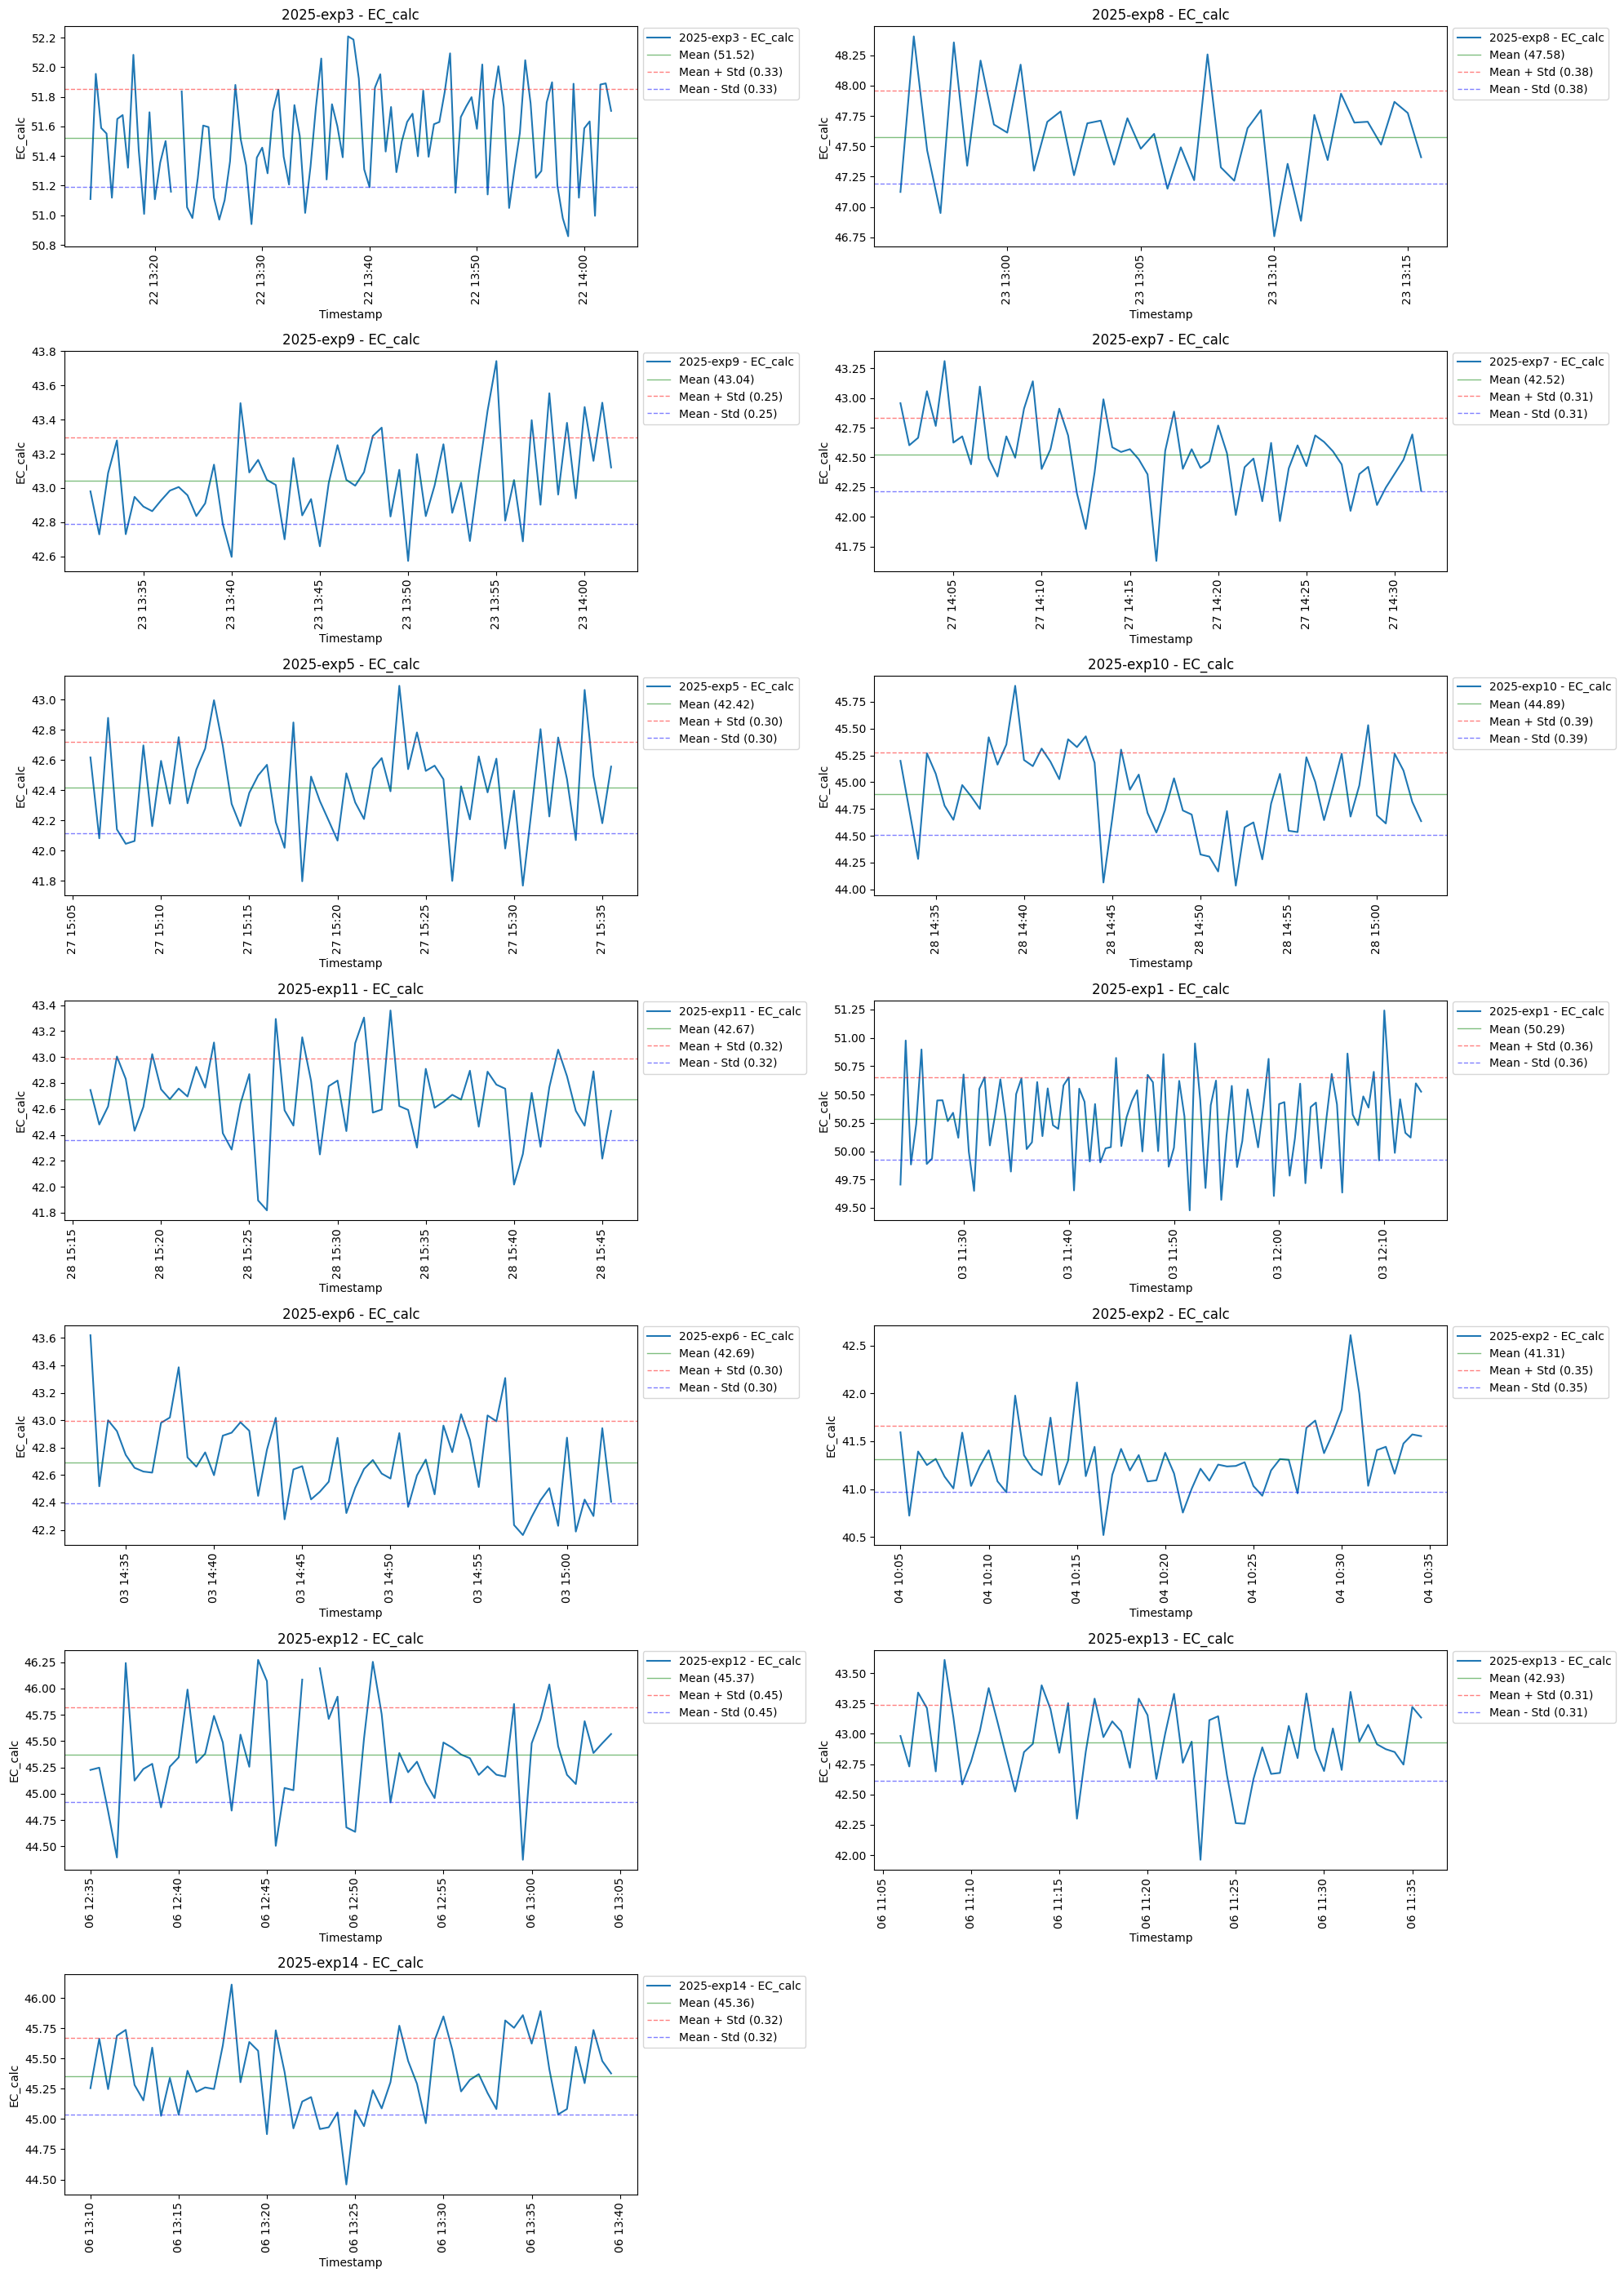

In [13]:
import matplotlib.pyplot as plt

def plot_sensor_data(sensor_name):
    # Filter dict to contain only dataframes with the desired column
    filtered_dict = {key: df for key, df in merged_dict.items() if sensor_name in df.columns}

    # Determine the number of subplots needed
    num_plots = len(filtered_dict)
    num_cols = 2
    num_rows = (num_plots + num_cols - 1) // num_cols

    # Create a figure and a grid of subplots
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(20, 4 * num_rows))
    axes = axes.flatten()

    # Iterate over the filtered dictionary and plot the sensor data
    for i, (key, df) in enumerate(filtered_dict.items()):
        # Plot the sensor data
        timestamp = df['timestamp']
        sensor_data = df[sensor_name]
        
        axes[i].plot(timestamp, sensor_data, label=f'{key} - {sensor_name}')
        
        # Calculate the mean and standard deviation
        mean_val = sensor_data.mean()
        std_val = sensor_data.std()

        # Plot mean and std lines with lower alpha and thinner lines
        axes[i].axhline(mean_val, color='green', linestyle='-', alpha=0.5, linewidth=1, label=f'Mean ({mean_val:.2f})')
        axes[i].axhline(mean_val + std_val, color='red', linestyle='--', alpha=0.5, linewidth=1, label=f'Mean + Std ({std_val:.2f})')
        axes[i].axhline(mean_val - std_val, color='blue', linestyle='--', alpha=0.5, linewidth=1, label=f'Mean - Std ({std_val:.2f})')

        # Add legend and labels
        axes[i].legend(bbox_to_anchor=(1, 1.02))
        axes[i].tick_params(axis='x', rotation=90)
        axes[i].set_title(f'{key} - {sensor_name}')
        axes[i].set_xlabel('Timestamp')
        axes[i].set_ylabel(sensor_name)

    # Remove any unused subplots
    for j in range(num_plots, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()

plot_sensor_data('EC_calc')

# Delivery to Sindrey

## 1 Groupby Enthalpy

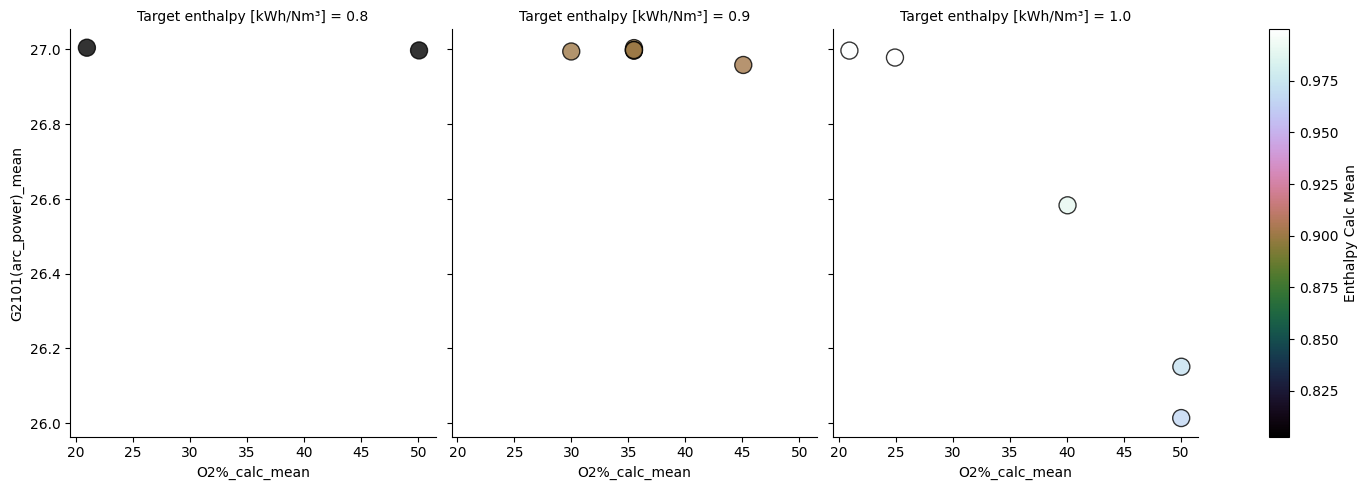

In [14]:
import seaborn as sns
import matplotlib.pyplot as plt

# Create the relplot with hue mapped to 'enthalpy_calc_mean'
g = sns.relplot(
    data=final_df,
    x='O2%_calc_mean',
    y='G2101(arc_power)_mean',
    col='Target enthalpy [kWh/Nm³]',
    s=150,
    alpha=0.8,
    hue='enthalpy_calc_mean',
    legend=False,
    palette='cubehelix',
    marker='o',
    edgecolor='black'
)

# Add a color bar to represent the hue values
norm = plt.Normalize(final_df['enthalpy_calc_mean'].min(), final_df['enthalpy_calc_mean'].max())
sm = plt.cm.ScalarMappable(cmap='cubehelix', norm=norm)
sm.set_array([])

# Adjust the color bar position and size according to your layout
g.fig.colorbar(sm, ax=g.axes, label='Enthalpy Calc Mean')

plt.show()

## 2 Group by Enthalpy for Åsmund

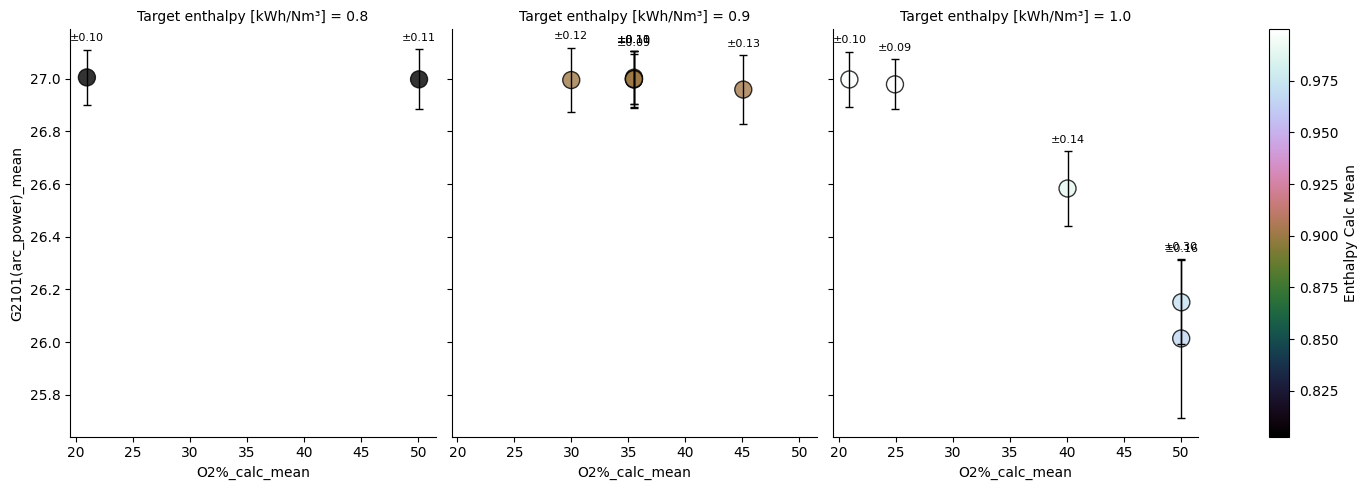

In [15]:
import seaborn as sns
import matplotlib.pyplot as plt

# Create the base plot
g = sns.relplot(
    data=final_df,
    x='O2%_calc_mean',
    y='G2101(arc_power)_mean',
    col='Target enthalpy [kWh/Nm³]',
    hue='enthalpy_calc_mean',
    palette='cubehelix',
    marker='o',
    s=150,
    alpha=0.8,
    edgecolor='black',
    legend=False
)

# Loop over each subplot within the FacetGrid
for ax, (_, subset) in zip(g.axes.flat, final_df.groupby('Target enthalpy [kWh/Nm³]')):
    # Plot error bars
    ax.errorbar(
        subset['O2%_calc_mean'],
        subset['G2101(arc_power)_mean'],
        yerr=subset['G2101(arc_power)_std'],
        fmt='none',
        ecolor='black',
        elinewidth=1,
        capsize=3
    )
    
    # Annotate each point with its standard deviation value
    for i, row in subset.iterrows():
        ax.text(
            row['O2%_calc_mean'],
            row['G2101(arc_power)_mean'] + row['G2101(arc_power)_std'] + 0.025,  # Position text above the whisker
            f"±{row['G2101(arc_power)_std']:.2f}",
            fontsize=8,
            ha='center',
            va='bottom'
        )

# Add a color bar to represent the hue values
norm = plt.Normalize(final_df['enthalpy_calc_mean'].min(), final_df['enthalpy_calc_mean'].max())
sm = plt.cm.ScalarMappable(cmap='cubehelix', norm=norm)
sm.set_array([])  
g.fig.colorbar(sm, ax=g.axes, label='Enthalpy Calc Mean')

plt.show()


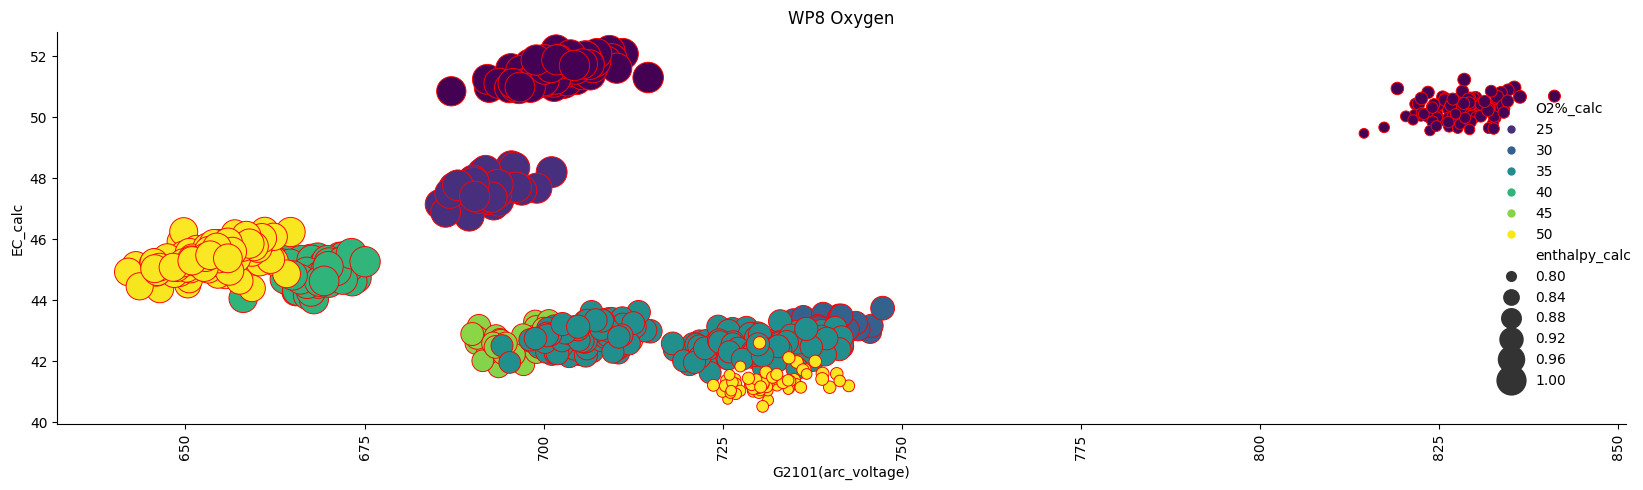

In [16]:
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

# Define a colormap and normalize the hue
cmap = sns.color_palette("viridis", as_cmap=True)
hue_norm = mcolors.Normalize(vmin=merged_influx_df['O2%_calc'].min(), vmax=merged_influx_df['O2%_calc'].max())

# Plot the data with marker size based on 'O2%_calc'
g = sns.relplot(
    data=merged_influx_df,
    x='G2101(arc_voltage)',
    y='EC_calc',
    aspect=3,
    size='enthalpy_calc',  # Use size parameter for 'O2%_calc'
    sizes=(50, 500),  # Define min and max size for markers
    edgecolor='red',
    hue='O2%_calc',
    palette=cmap,
    hue_norm=hue_norm,
    legend='brief'  # Show legend
)

# Customize legend
handles, labels = g.ax.get_legend_handles_labels()
plt.title('WP8 Oxygen')
plt.xticks(rotation=90)
plt.tight_layout()

plt.show()

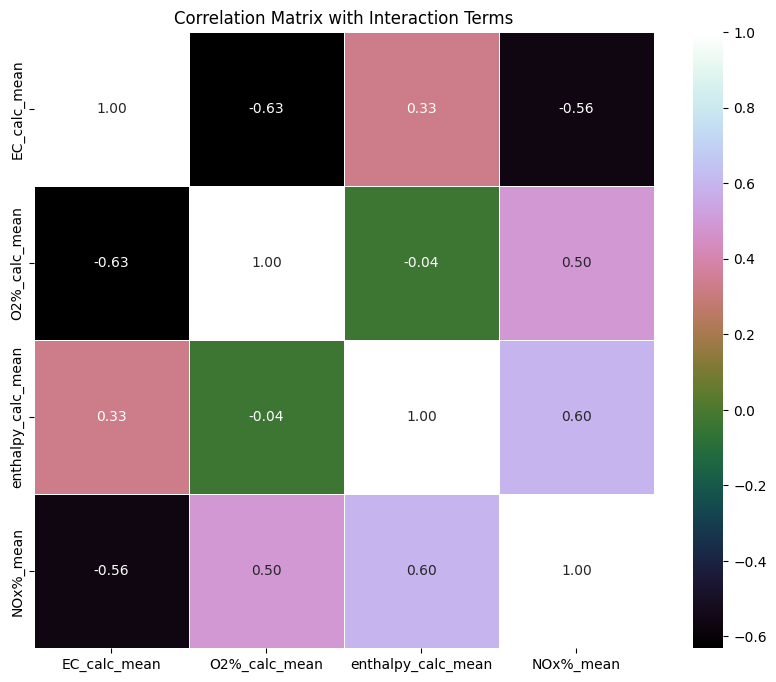

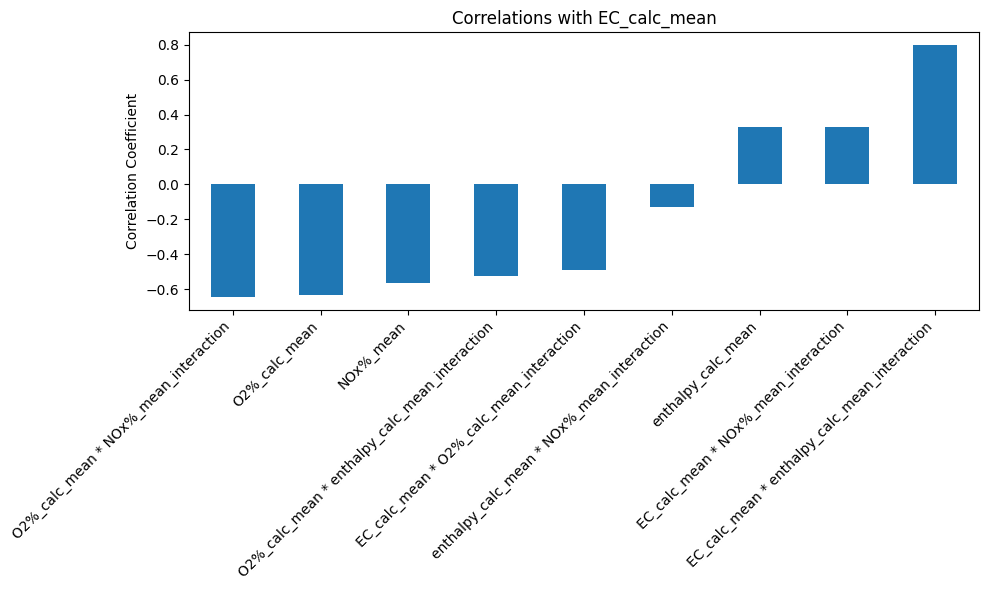

In [17]:
# h = final_df[['EC_calc_mean', 'O2%_calc_mean', 'enthalpy_calc_mean', 'NOx%_mean']]
# hh = h.corr()
# sns.heatmap(hh, annot=True, cmap='cubehelix')

import pandas as pd
import itertools
import seaborn as sns
import matplotlib.pyplot as plt

# Specify the columns you want to include in the interaction
selected_columns = ['EC_calc_mean', 'O2%_calc_mean', 'enthalpy_calc_mean', 'NOx%_mean']

# Create a new DataFrame to hold the selected columns and their interaction terms
interaction_df = final_df[selected_columns].copy()

# # Generate all possible two-way interaction terms
# for col1, col2 in itertools.combinations(selected_columns, 2):
#     interaction_term_name = f"{col1} x {col2}_interaction"
#     interaction_df[interaction_term_name] = final_df[col1] * final_df[col2]

# Compute the correlation matrix including interaction terms
corr_matrix = interaction_df.corr()

# Plot the correlation heatmap
plt.figure(figsize=(10, 8))  # Adjust the size for readability
sns.heatmap(corr_matrix, annot=True, cmap='cubehelix', fmt=".2f", linewidths=0.5)
plt.title("Correlation Matrix with Interaction Terms")
plt.show()

import itertools
import pandas as pd
import matplotlib.pyplot as plt

# Specify columns
selected_cols = ['EC_calc_mean', 'O2%_calc_mean', 'enthalpy_calc_mean', 'NOx%_mean']

# Prepare DataFrame with interaction terms
interaction_df = final_df[selected_cols].copy()
for col1, col2 in itertools.combinations(selected_cols, 2):
    interaction_df[f"{col1} * {col2}_interaction"] = final_df[col1] * final_df[col2]

# Extract correlations with 'EC_calc_mean'
ec_corr = interaction_df.corr()['EC_calc_mean'].drop('EC_calc_mean')

# Plot as a bar chart
ec_corr.sort_values().plot(kind='bar', figsize=(10, 6), title='Correlations with EC_calc_mean', ylabel='Correlation Coefficient')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

## Random forest

C:\Users\Admin Henry Chen\AppData\Local\Temp\ipykernel_43124\1245198335.py:7: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  clean_df = final_df.select_dtypes(include=[float, int]).dropna(subset=['EC_calc_mean']).fillna(method='ffill')


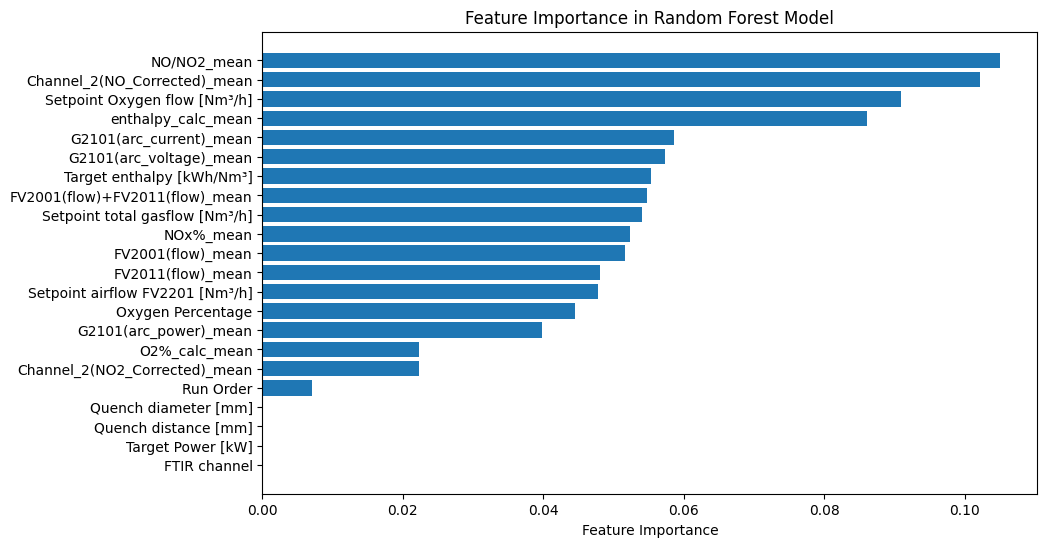

In [18]:
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# Handle missing values
clean_df = final_df.select_dtypes(include=[float, int]).dropna(subset=['EC_calc_mean']).fillna(method='ffill')
clean_df = clean_df.loc[:, ~clean_df.columns.str.contains('cv|std')]

if 'EC_calc_mean' in clean_df.columns:
    X, y = clean_df.drop(columns='EC_calc_mean'), clean_df['EC_calc_mean']

    if not X.empty:
        
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

        model = RandomForestRegressor(random_state=42)
        model.fit(X_train, y_train)

        importances = model.feature_importances_
        features = X.columns

        # Plot feature importances
        plt.figure(figsize=(10, 6))
        indices = importances.argsort()
        plt.barh(range(len(indices)), importances[indices], tick_label=features[indices])
        plt.xlabel('Feature Importance')
        plt.title('Feature Importance in Random Forest Model')
        plt.show()
    else:
        print("No valid data to train on after cleaning.")
else:
    print("EC_calc_mean not present in clean DataFrame.")

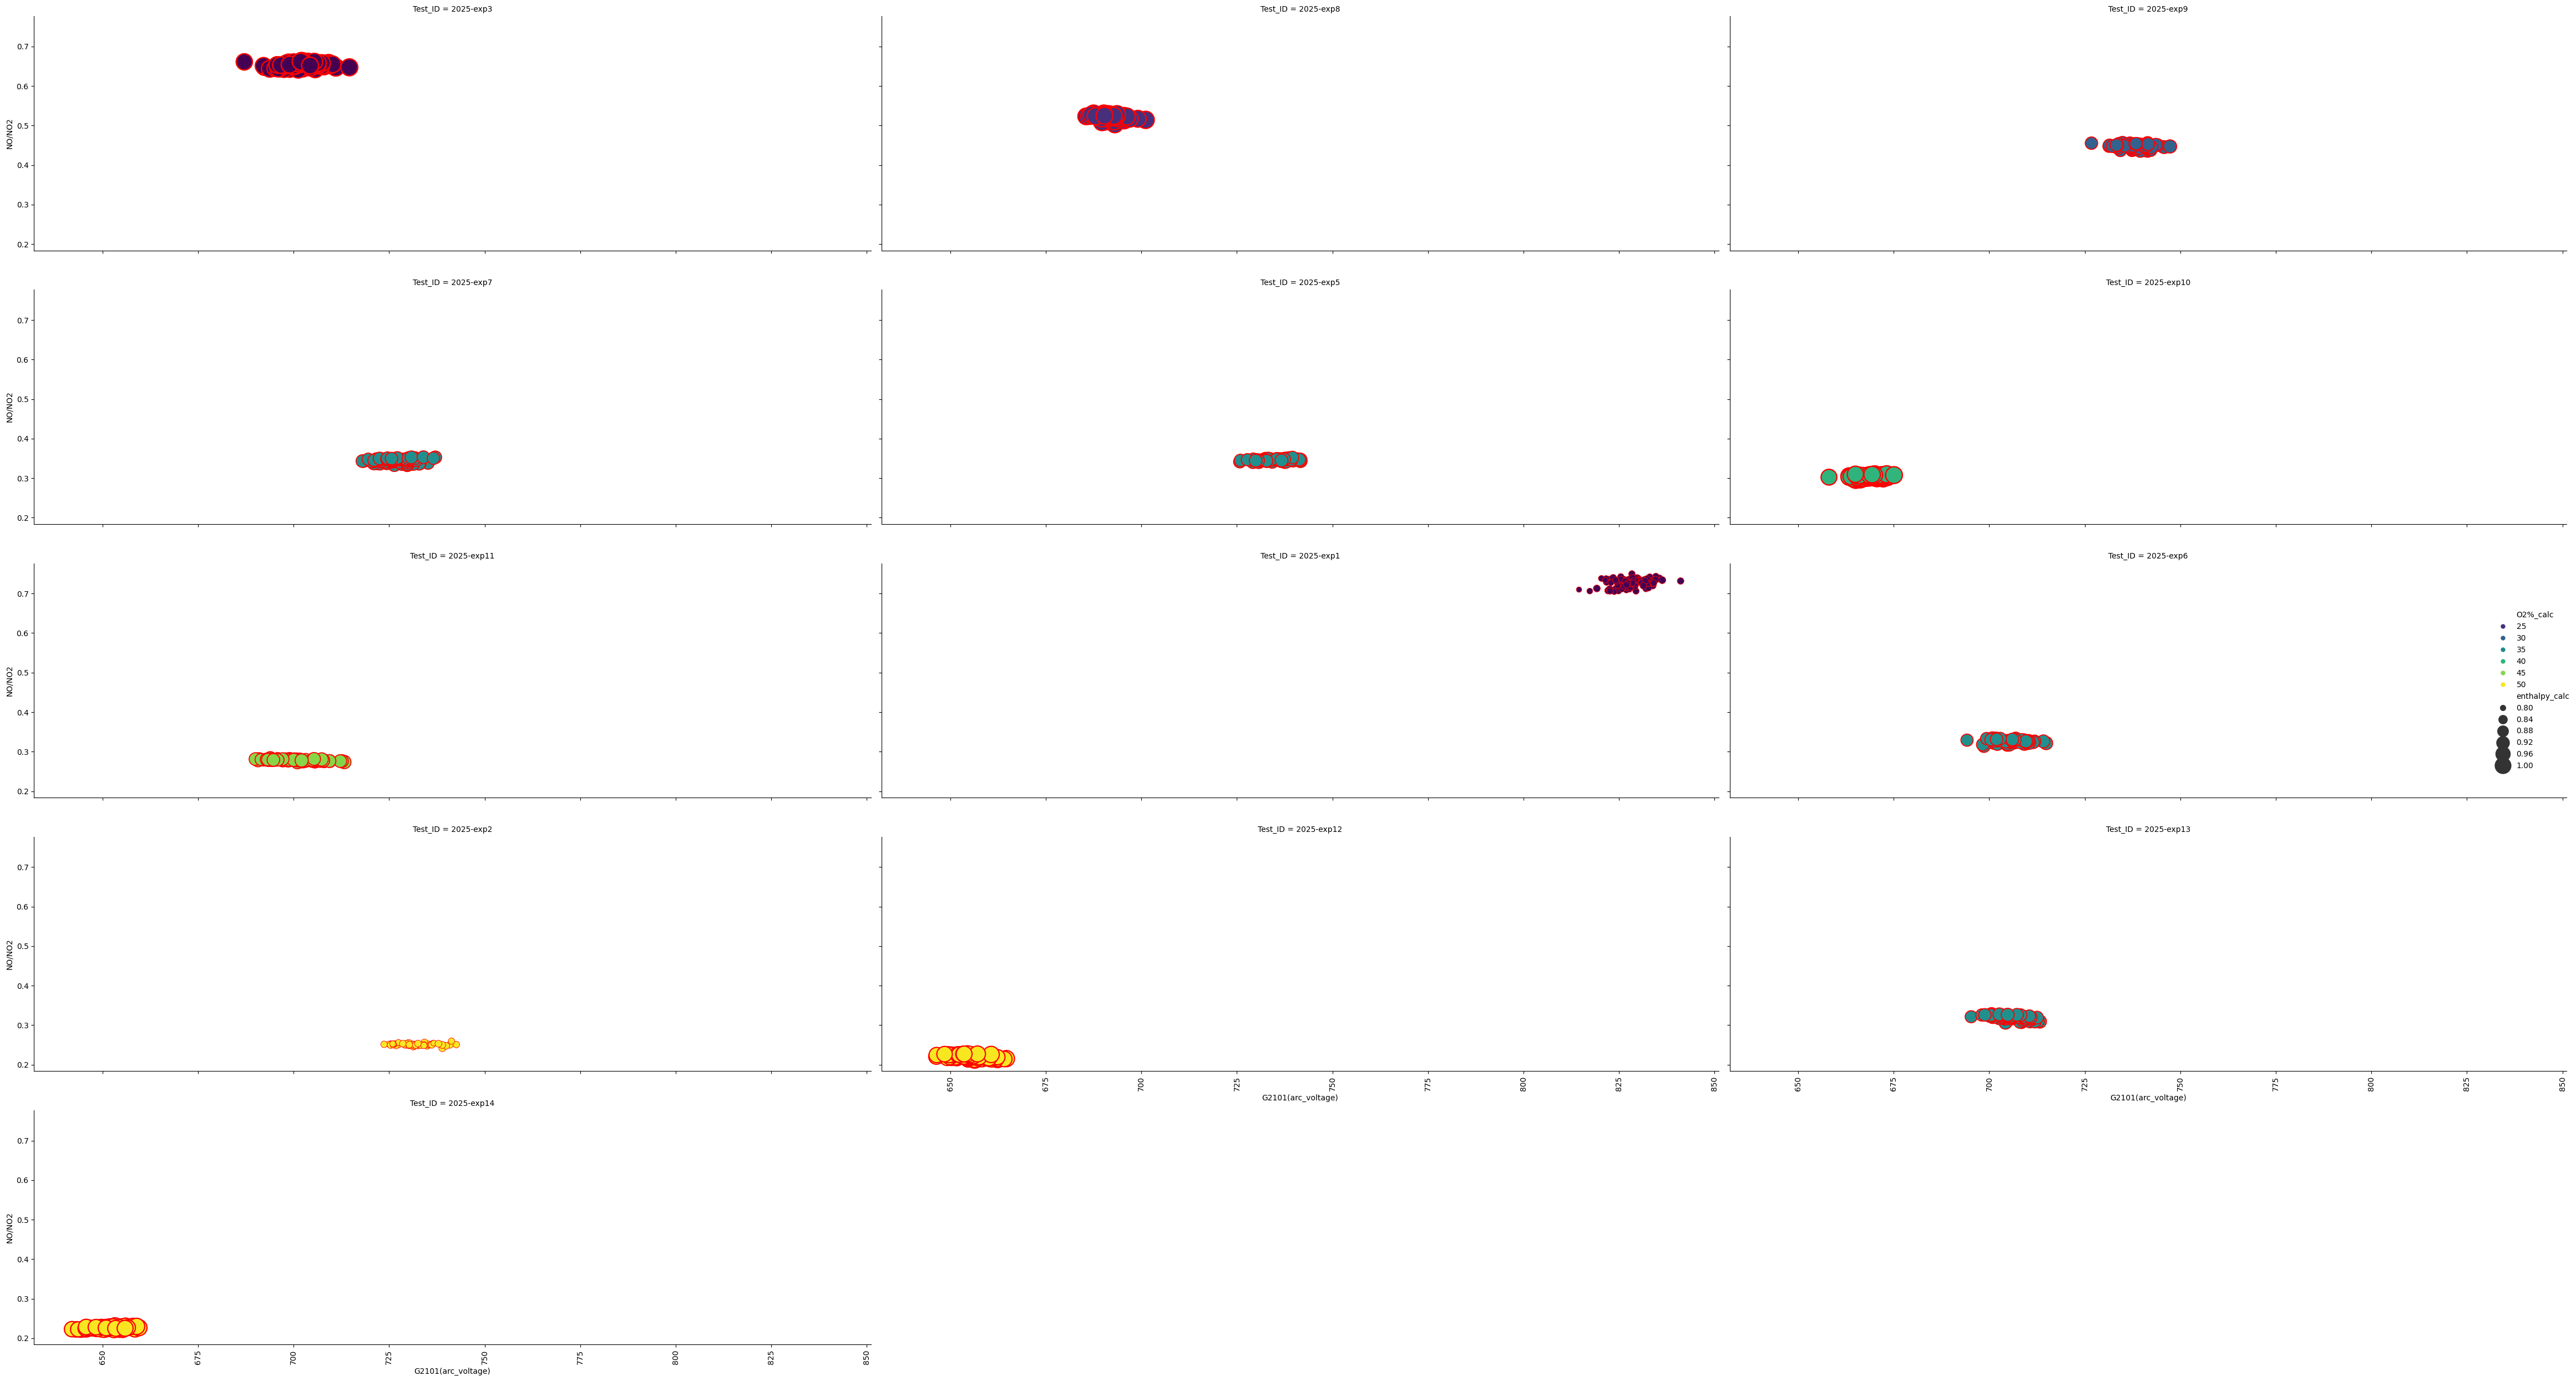

In [19]:
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

# Create a list to store DataFrames with Test_ID
dfs_with_id = []

# Add Test_ID to each DataFrame in the merged_dict
for Test_ID, df in merged_dict.items():
    df_copy = df.copy()
    df_copy['Test_ID'] = Test_ID
    dfs_with_id.append(df_copy)

# Concatenate all DataFrames
plot_df = pd.concat(dfs_with_id, ignore_index=True)

# Normalize the hue
cmap = sns.color_palette("viridis", as_cmap=True)
hue_norm = mcolors.Normalize(vmin=plot_df['O2%_calc'].min(), vmax=plot_df['O2%_calc'].max())

# Plotting with the correct column name
g = sns.relplot(
    data=plot_df,
    x='G2101(arc_voltage)',
    y='NO/NO2',
    aspect=3,
    size='enthalpy_calc',
    sizes=(50, 500),
    edgecolor='red',
    hue='O2%_calc',
    palette=cmap,
    hue_norm=hue_norm,
    col='Test_ID',
    col_wrap=3,
    legend='brief'
)

# Rotate x-ticks and adjust layout
for ax in g.axes:
    ax.tick_params(axis='x', rotation=90)

plt.tight_layout()
plt.show()

<Axes: xlabel='G2101(arc_voltage)', ylabel='G2101(arc_power)'>

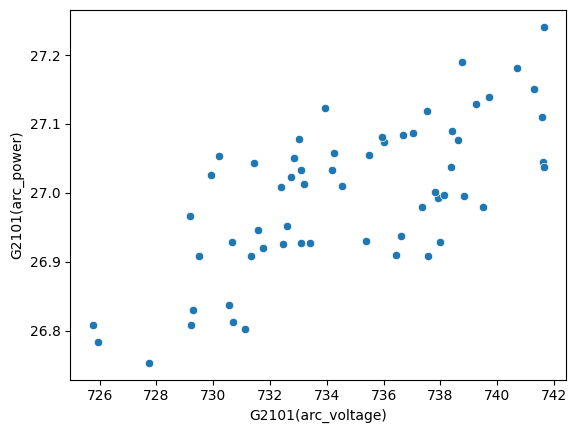

In [20]:
sns.scatterplot(data=merged_dict['2025-exp5'], x='G2101(arc_voltage)', y='G2101(arc_power)')

## Replicates

In [21]:
import pandas as pd
g = (final_df.loc[final_df['Test_ID'].isin(['2025-exp6', '2025-exp7', '2025-exp5', '2025-exp13']), ['Test_ID',
                                                                                                     'O2%_calc_mean',
                                                                                                       'enthalpy_calc_mean',
                                                                                                       'enthalpy_calc_std',
                                                                                                         'G2101(arc_voltage)_mean',
                                                                                                           'G2101(arc_voltage)_std',
                                                                                                             'EC_calc_mean',
                                                                                                             'EC_calc_std',
                                                                                                               'NOx%_mean']])
print(g.to_string())

print('\n')

import pandas as pd
g = (final_df.loc[final_df['Test_ID'].isin(['2025-exp12', '2025-exp14']), ['Test_ID',
                                                                            'O2%_calc_mean',
                                                                            'enthalpy_calc_mean',
                                                                            'enthalpy_calc_std',
                                                                                'G2101(arc_voltage)_mean',
                                                                                'G2101(arc_voltage)_std',
                                                                                    'EC_calc_mean',
                                                                                    'EC_calc_std',
                                                                                    'NOx%_mean']])
print(g.to_string())

       Test_ID  O2%_calc_mean  enthalpy_calc_mean  enthalpy_calc_std  G2101(arc_voltage)_mean  G2101(arc_voltage)_std  EC_calc_mean  EC_calc_std  NOx%_mean
3    2025-exp7      35.489310            0.900409           0.004216               726.796060                4.501487     42.522482     0.308490   3.388359
4    2025-exp5      35.485184            0.900153           0.004170               734.754886                4.128524     42.417691     0.301759   3.395750
8    2025-exp6      35.483068            0.900289           0.004298               706.105012                4.137606     42.692394     0.301711   3.374432
11  2025-exp13      35.482421            0.900265           0.004330               705.589821                3.990228     42.926173     0.313380   3.355944


       Test_ID  O2%_calc_mean  enthalpy_calc_mean  enthalpy_calc_std  G2101(arc_voltage)_mean  G2101(arc_voltage)_std  EC_calc_mean  EC_calc_std  NOx%_mean
10  2025-exp12      50.039855            0.966516           0.

## Test 1 model

In [22]:
# import numpy as np
# import matplotlib.pyplot as plt
# from mpl_toolkits.mplot3d import Axes3D
# from sklearn.preprocessing import PolynomialFeatures
# from sklearn.linear_model import LinearRegression
# from sklearn.model_selection import cross_val_score

# # Extract columns from the DataFrame
# X = final_df[['O2%_calc_mean', 'enthalpy_calc_mean']].values
# Z = final_df['EC_calc_mean'].values

# # Use PolynomialFeatures to add polynomial terms (e.g., quadratic)
# poly = PolynomialFeatures(degree=2)
# X_poly = poly.fit_transform(X)

# # Fit the model
# model = LinearRegression()
# model.fit(X_poly, Z)

# # Calculate R² score
# r2 = model.score(X_poly, Z)
# print(f'R² score: {r2:.4f}')

# # Calculate Q² score using cross-validation
# q2 = cross_val_score(model, X_poly, Z, cv=5, scoring='r2').mean()
# print(f'Q² score (5-fold CV): {q2:.4f}')

# # Create a grid for plotting the surface
# xx, yy = np.meshgrid(np.linspace(X[:,0].min(), X[:,0].max(), 100),
#                      np.linspace(X[:,1].min(), X[:,1].max(), 100))

# # Transform the grid for prediction
# grid = np.c_[xx.ravel(), yy.ravel()]
# grid_poly = poly.transform(grid)

# # Predict the Z values on the grid
# zz = model.predict(grid_poly).reshape(xx.shape)

# # Create a 3D plot
# fig = plt.figure()
# ax = fig.add_subplot(111, projection='3d')

# # Plot the original data points
# ax.scatter(X[:,0], X[:,1], Z, c='r', marker='o')

# # Plot the fitted polynomial surface
# ax.plot_surface(xx, yy, zz, color='b', alpha=0.5)

# # Set labels
# ax.set_xlabel('O2%_calc_mean')
# ax.set_ylabel('enthalpy_calc_mean')
# ax.set_zlabel('EC_calc_mean')

# # Show plot
# plt.show()


## mean + std whiskers

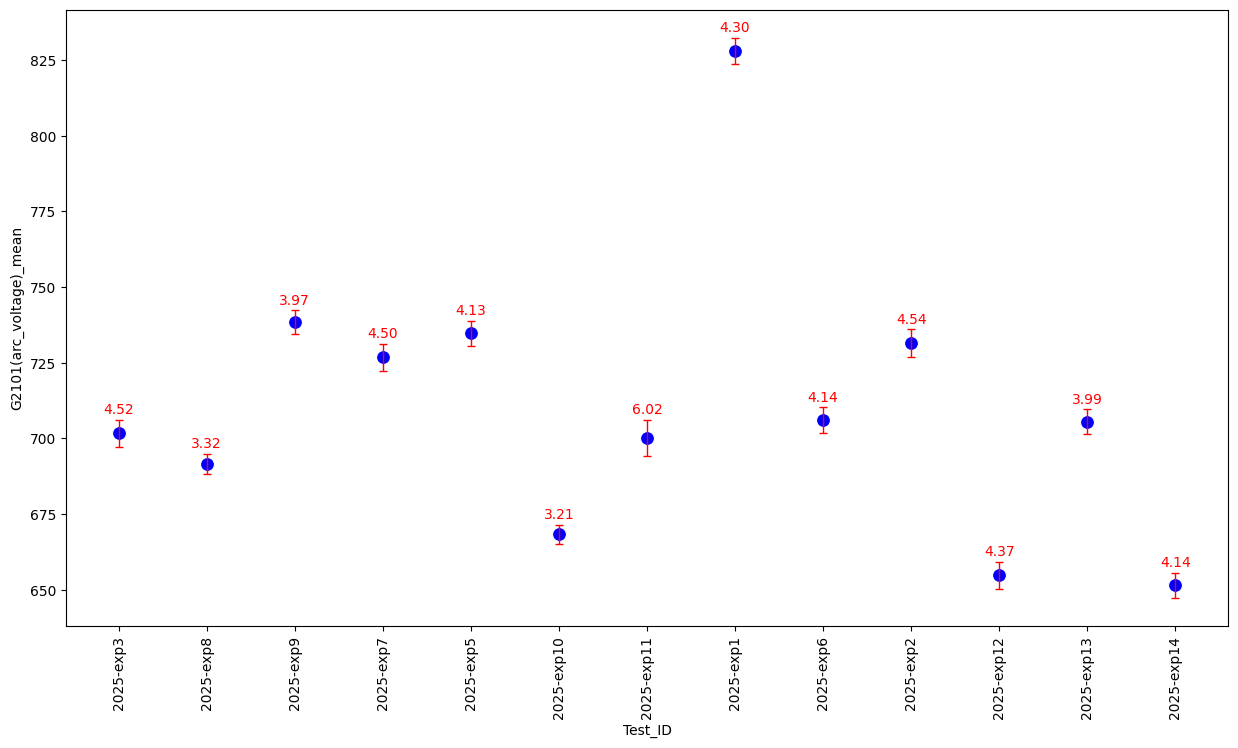

In [23]:
import seaborn as sns
import matplotlib.pyplot as plt

test_ids, means, stds = final_df['Test_ID'], final_df['G2101(arc_voltage)_mean'], final_df['G2101(arc_voltage)_std']

fig, ax1 = plt.subplots(figsize=(15, 8))
sns.scatterplot(x=test_ids, y=means, ax=ax1, s=100, color='blue', marker='o')

ax1.errorbar(test_ids, means, yerr=stds, fmt='none', ecolor='red', elinewidth=1, capsize=3)
[ax1.text(i, m + s + 2, f'{s:.2f}', color='red', ha='center') for i, (m, s) in enumerate(zip(means, stds))]

ax1.tick_params(axis='x', rotation=90)
plt.show()

## Compare plots

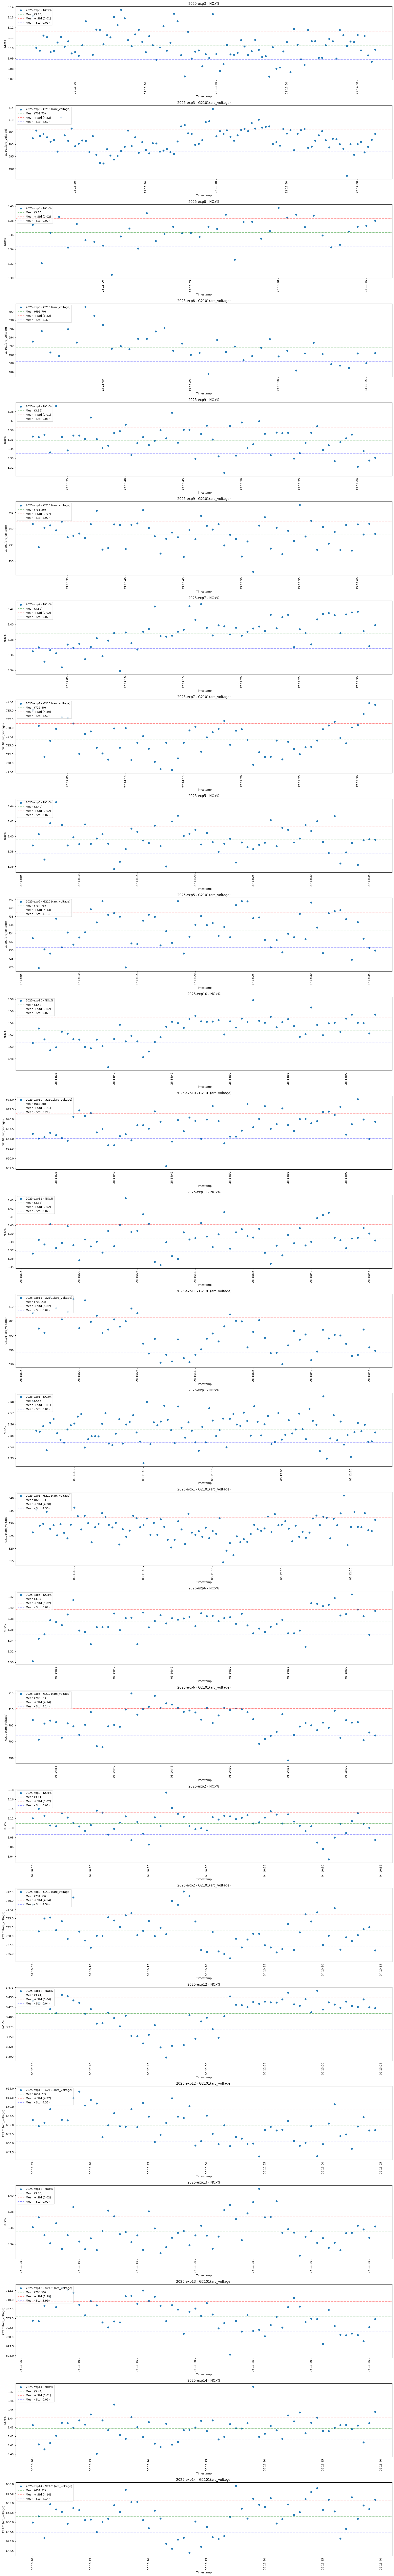

In [24]:
import matplotlib.pyplot as plt

def plot_sensor_data(*sensor_names):
    fig, axes = plt.subplots(len(merged_dict) * len(sensor_names), 1, figsize=(20, 5 * len(merged_dict) * len(sensor_names)))
    
    for i, (key, df) in enumerate(merged_dict.items()):
        for j, sensor_name in enumerate(sensor_names):
            ax = axes[i * len(sensor_names) + j]
            if sensor_name not in df.columns:
                ax.set_visible(False)
                continue

            sensor_data = df[sensor_name]
            ax.scatter(df['timestamp'], sensor_data, label=f'{key} - {sensor_name}')
            
            mean_val = sensor_data.mean()
            std_val = sensor_data.std()

            ax.axhline(mean_val, color='green', linestyle='--', alpha=0.5, linewidth=1, label=f'Mean ({mean_val:.2f})')
            ax.axhline(mean_val + std_val, color='red', linestyle='--', alpha=0.5, linewidth=1, label=f'Mean + Std ({std_val:.2f})')
            ax.axhline(mean_val - std_val, color='blue', linestyle='--', alpha=0.5, linewidth=1, label=f'Mean - Std ({std_val:.2f})')

            ax.legend(loc='upper left')
            ax.tick_params(axis='x', rotation=90)
            ax.set_title(f'{key} - {sensor_name}')
            ax.set_xlabel('Timestamp')
            ax.set_ylabel(sensor_name)
    
    plt.tight_layout()
    plt.show()

plot_sensor_data('NOx%', 'G2101(arc_voltage)')